# Time Series Forecasting with LSTMs for Daily Coronavirus Cases using PyTorch in Python

Hello everyone I am Erfan Moghadam.
In this project we will build a model to predict daily COVID-19 cases using LSTM (Long Short-Term Memory).
Lets get started!

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Daily Cases Dataset

The data is provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) and contains the number of reported daily cases by country.We add The data Manually.

## Data Exploration


Lets Load the data and take a look at it:

In [ ]:
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/27/22,7/28/22,7/29/22,7/30/22,7/31/22,8/1/22,8/2/22,8/3/22,8/4/22,8/5/22
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,185272,185393,185481,185552,185749,185930,186120,186393,186697,187037
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,308050,309278,310362,311381,312097,312375,313582,314561,315337,316145
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,267096,267194,267287,267374,267454,267546,267657,267777,267902,268033
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,45326,45508,45508,45508,45508,45508,45508,45793,45793,45793
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,102301,102301,102301,102301,102301,102301,102301,102301,102301,102636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,682096,682096,682096,682096,682096,682096,691065,691065,691065,691065
281,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
282,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11849,11849,11849,11877,11877,11877,11877,11877,11895,11895
283,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,329483,329483,329483,329483,329483,329483,330575,330575,330575,331074


Well, as you see we have 4 columns in this dataset that we dosent need to them, so I want to remove these columns:

In [ ]:
confirmed = confirmed.iloc[:,4:]
confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,7/27/22,7/28/22,7/29/22,7/30/22,7/31/22,8/1/22,8/2/22,8/3/22,8/4/22,8/5/22
0,0,0,0,0,0,0,0,0,0,0,...,185272,185393,185481,185552,185749,185930,186120,186393,186697,187037
1,0,0,0,0,0,0,0,0,0,0,...,308050,309278,310362,311381,312097,312375,313582,314561,315337,316145
2,0,0,0,0,0,0,0,0,0,0,...,267096,267194,267287,267374,267454,267546,267657,267777,267902,268033
3,0,0,0,0,0,0,0,0,0,0,...,45326,45508,45508,45508,45508,45508,45508,45793,45793,45793
4,0,0,0,0,0,0,0,0,0,0,...,102301,102301,102301,102301,102301,102301,102301,102301,102301,102636


I must mention a point: as the you see the number of daily cases in this data is cumulative and I am going to fix it.

Checking for missing values:

In [ ]:
confirmed.isnull().sum().sum()

0

Let's sum all rows, so we get the cumulative daily cases:

In [ ]:
daily_cases = confirmed.sum(axis=0)
daily_cases

1/22/20          557
1/23/20          657
1/24/20          944
1/25/20         1437
1/26/20         2120
             ...    
8/1/22     578281901
8/2/22     579452832
8/3/22     580599341
8/4/22     582017016
8/5/22     582916032
Length: 927, dtype: int64

Now turn the date into datetime data type:

In [ ]:
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases

2020-01-22          557
2020-01-23          657
2020-01-24          944
2020-01-25         1437
2020-01-26         2120
                ...    
2022-08-01    578281901
2022-08-02    579452832
2022-08-03    580599341
2022-08-04    582017016
2022-08-05    582916032
Length: 927, dtype: int64

Text(0.5, 1.0, 'Cumulative Daily Cases')

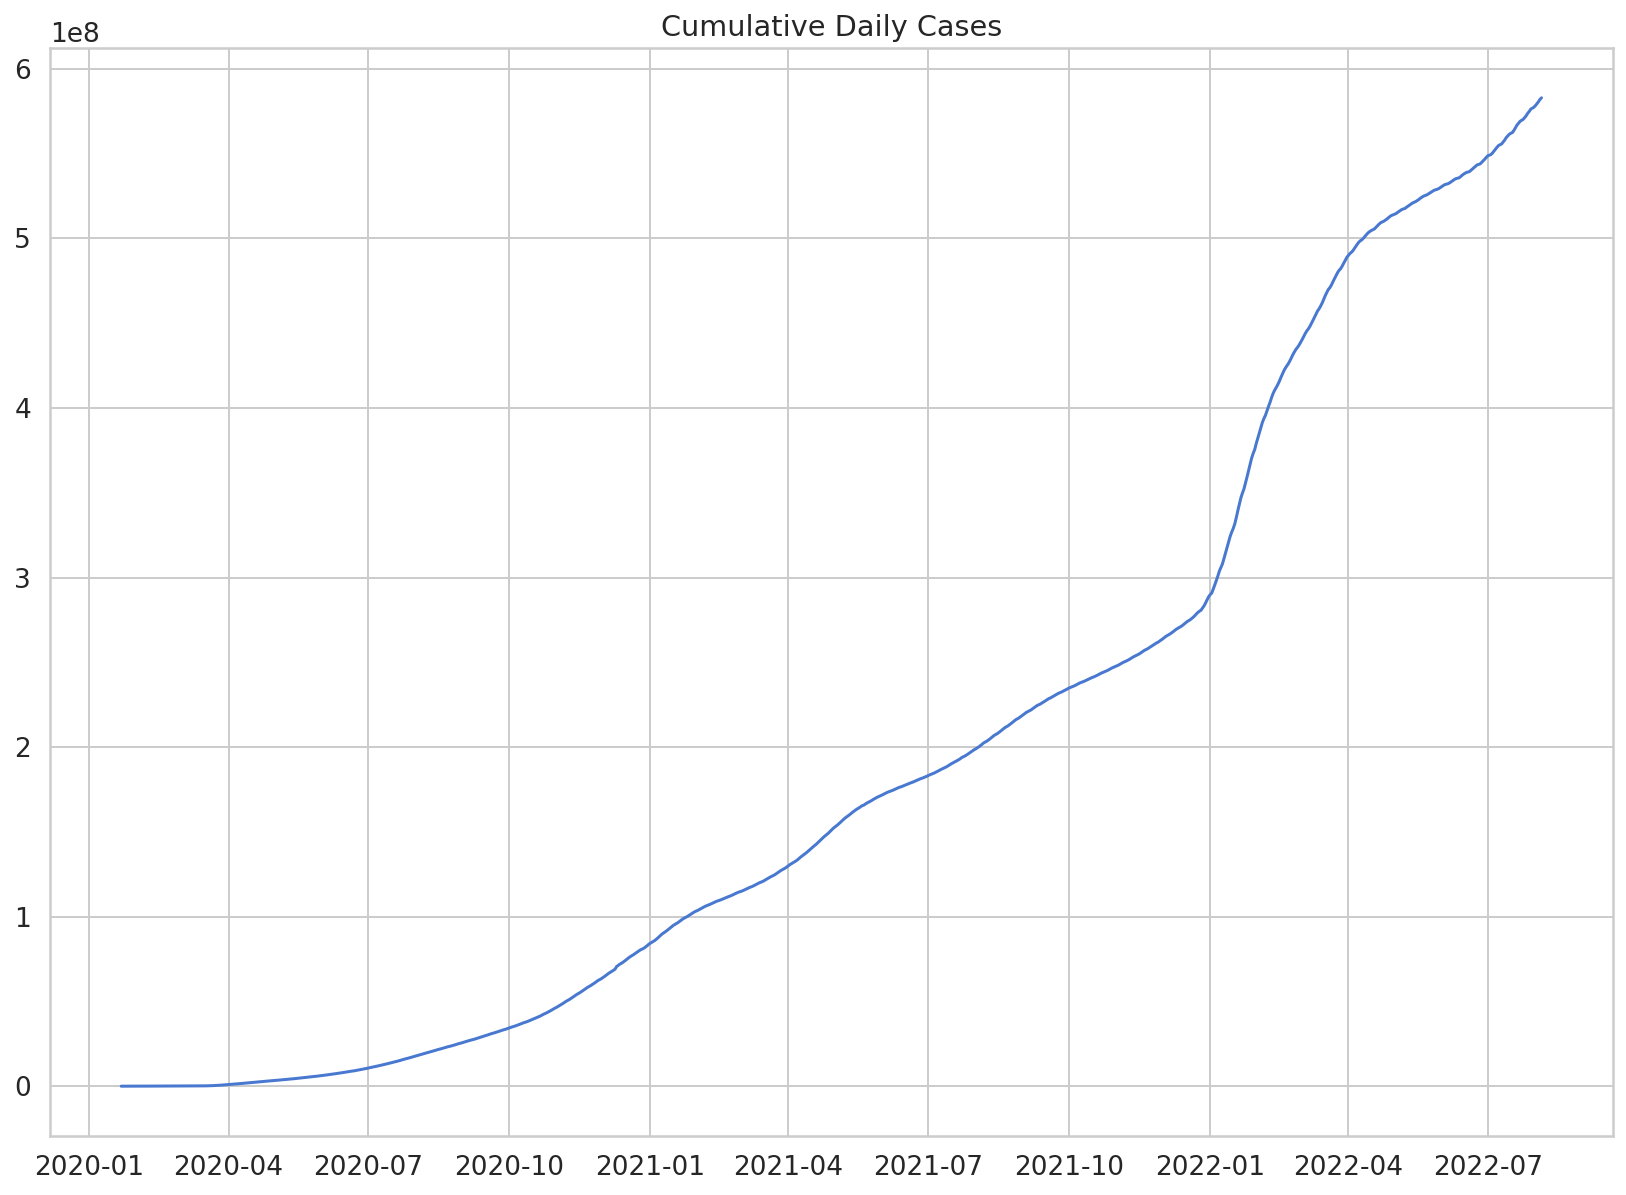

In [ ]:
plt.plot(daily_cases)
plt.title('Cumulative Daily Cases')

And now we will undo the accumulation by subtracting the current value from the previous. We will preserve the first value of the sequence:

In [ ]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases

2020-01-22        557
2020-01-23        100
2020-01-24        287
2020-01-25        493
2020-01-26        683
               ...   
2022-08-01     910073
2022-08-02    1170931
2022-08-03    1146509
2022-08-04    1417675
2022-08-05     899016
Length: 927, dtype: int64

Text(0.5, 1.0, 'Daily Cases')

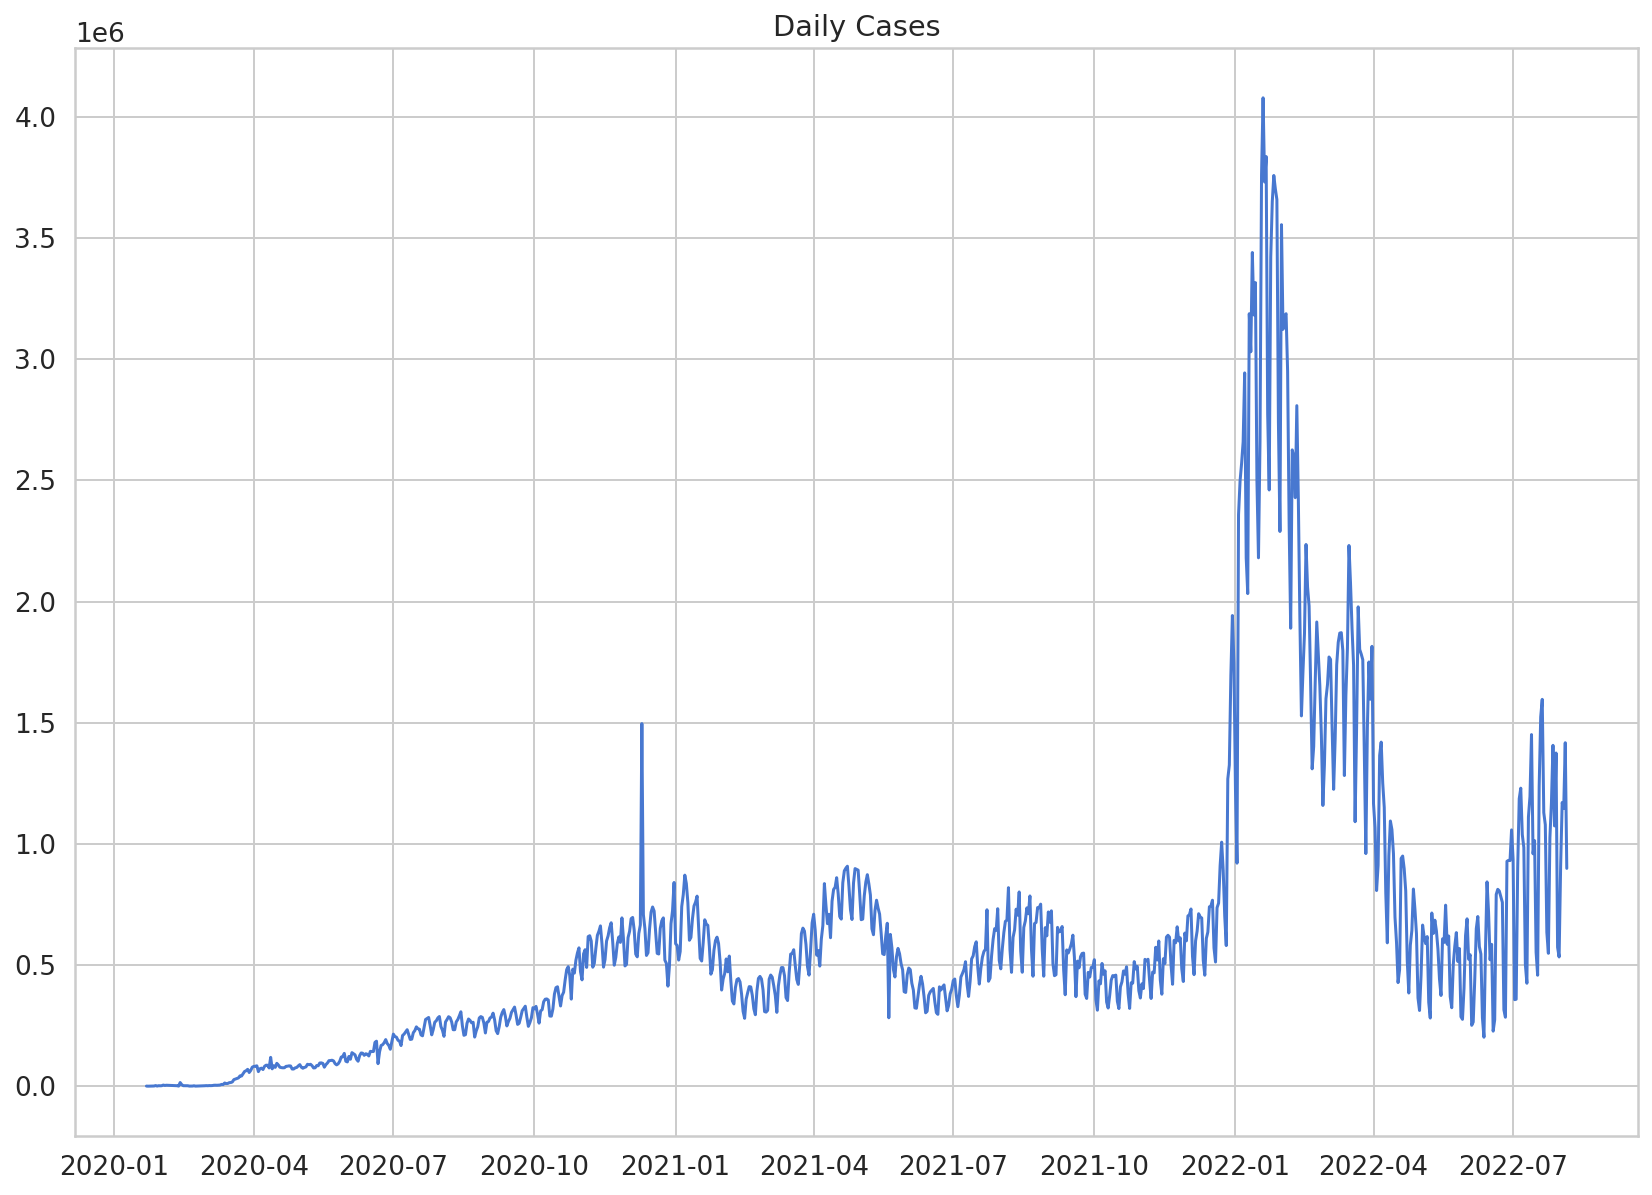

In [ ]:
plt.plot(daily_cases)
plt.title('Daily Cases')

Lets check amount of data we have:

In [ ]:
daily_cases.shape

(927,)

We have data for 919 days.

## Preprocessing

Data transformation for supervised learning data.

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

Dividing the dataset into traning, validation, and test sets:

In [ ]:
train_size = int(922 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+92], y[train_size:train_size+92]
X_test, y_test = X[train_size+92:], y[train_size+92:]

Min Max scaling:

In [ ]:
MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

Tensor transformation:

In [ ]:
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([737, 5]) torch.Size([92, 5]) torch.Size([92, 5])
torch.Size([737]) torch.Size([92]) torch.Size([92])


## Building a model

We will build the LSTM model. CovidPredictor consists of basic attributes, constructor for layer initialization, the reset_hidden_state function for resetting weights, and the forward function for prediction.

In [ ]:
class CovidPredictor(nn.Module):
    #constructor for layer initialization
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
            )
        #difining the output layer
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    #reset weights because LSTM is natrauly stateless
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    #create the neural network and prediction
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

## Training

Now we want build a helper function for the training of our model:

In [ ]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    # defining the loss function
    loss_fn = torch.nn.L1Loss()

     # defining the optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

    # definie parameters for saving loss values and predicted value
    train_hist = []
    val_hist = []

    # training the model
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data):

            # reset hidden state per seq because LSTM is stateless
            model.reset_hidden_state()

            # calculate train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # loss about 1 step

            # update weights in neural network
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        # pass the val_data to the model and calculate loss values for these data
        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):
                    # reset hidden state per seq
                    model.reset_hidden_state()

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss

            val_hist.append(val_loss / len(val_data)) # append in val hist

            ## print loss every verbose
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## check early stopping every patience
            if (t % patience == 0) & (t != 0):

                ## early stop if loss is on
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')


    return model, train_hist, val_hist

Let's create an instance of our model and train it:

In [ ]:
# definig the neural network model
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

# train
model, train_hist, val_hist = train_model(
    model,
    X_train,y_train,
    X_val,y_val,

    num_epochs=100,
    verbose=10,
    patience=50
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0 train loss: 0.044294842915657495 val loss: 0.12806792557239532
Epoch 10 train loss: 0.017835089116100742 val loss: 0.06576617807149887
Epoch 20 train loss: 0.01790897785167853 val loss: 0.06400571763515472
Epoch 30 train loss: 0.017791453058939755 val loss: 0.06172816827893257
Epoch 40 train loss: 0.017590364802664613 val loss: 0.06325773894786835
Epoch 50 train loss: 0.017948362893937347 val loss: 0.061067406088113785
Epoch 60 train loss: 0.01802636950079028 val loss: 0.06372351199388504
Epoch 70 train loss: 0.01770954310151292 val loss: 0.0650549903512001
Epoch 80 train loss: 0.017717124011589966 val loss: 0.06327055394649506
Epoch 90 train loss: 0.01767507997087773 val loss: 0.061037659645080566


Lets have a look at train and test loss:

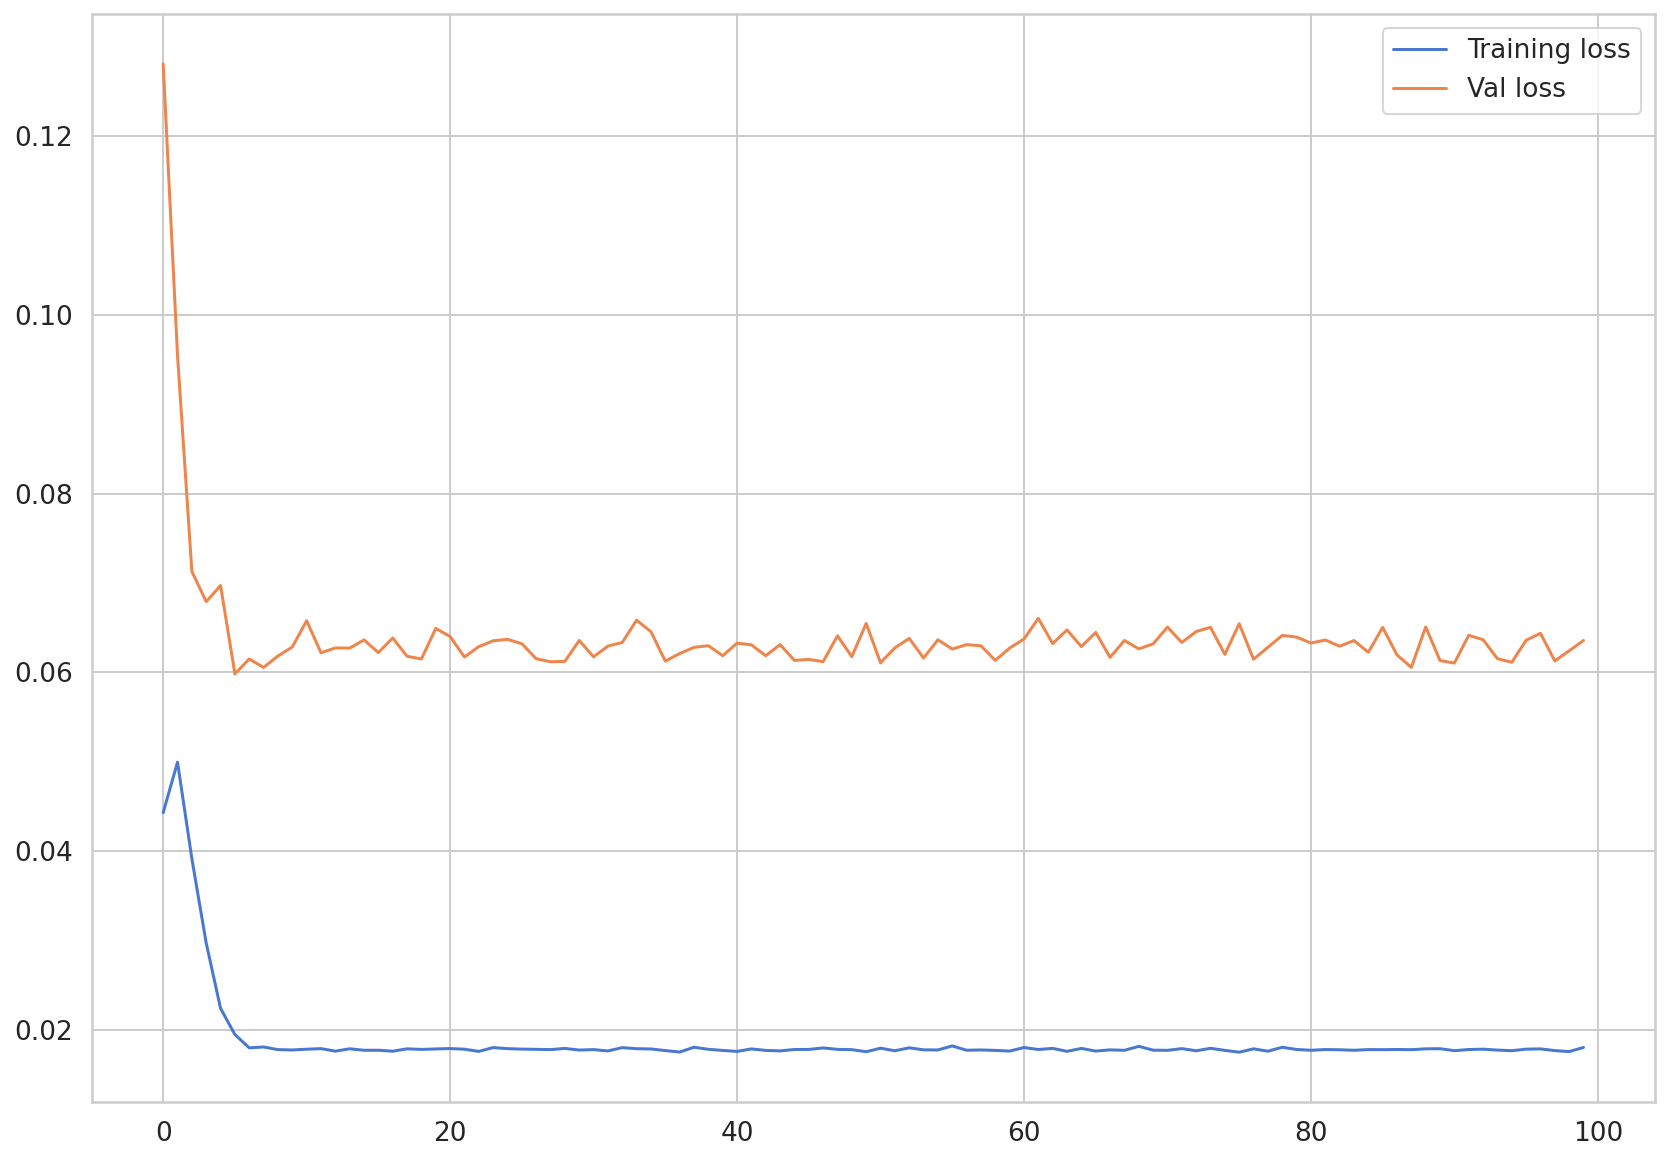

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend();

## Predicting Daily Cases

One step prediction:

In [ ]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for i in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[i], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

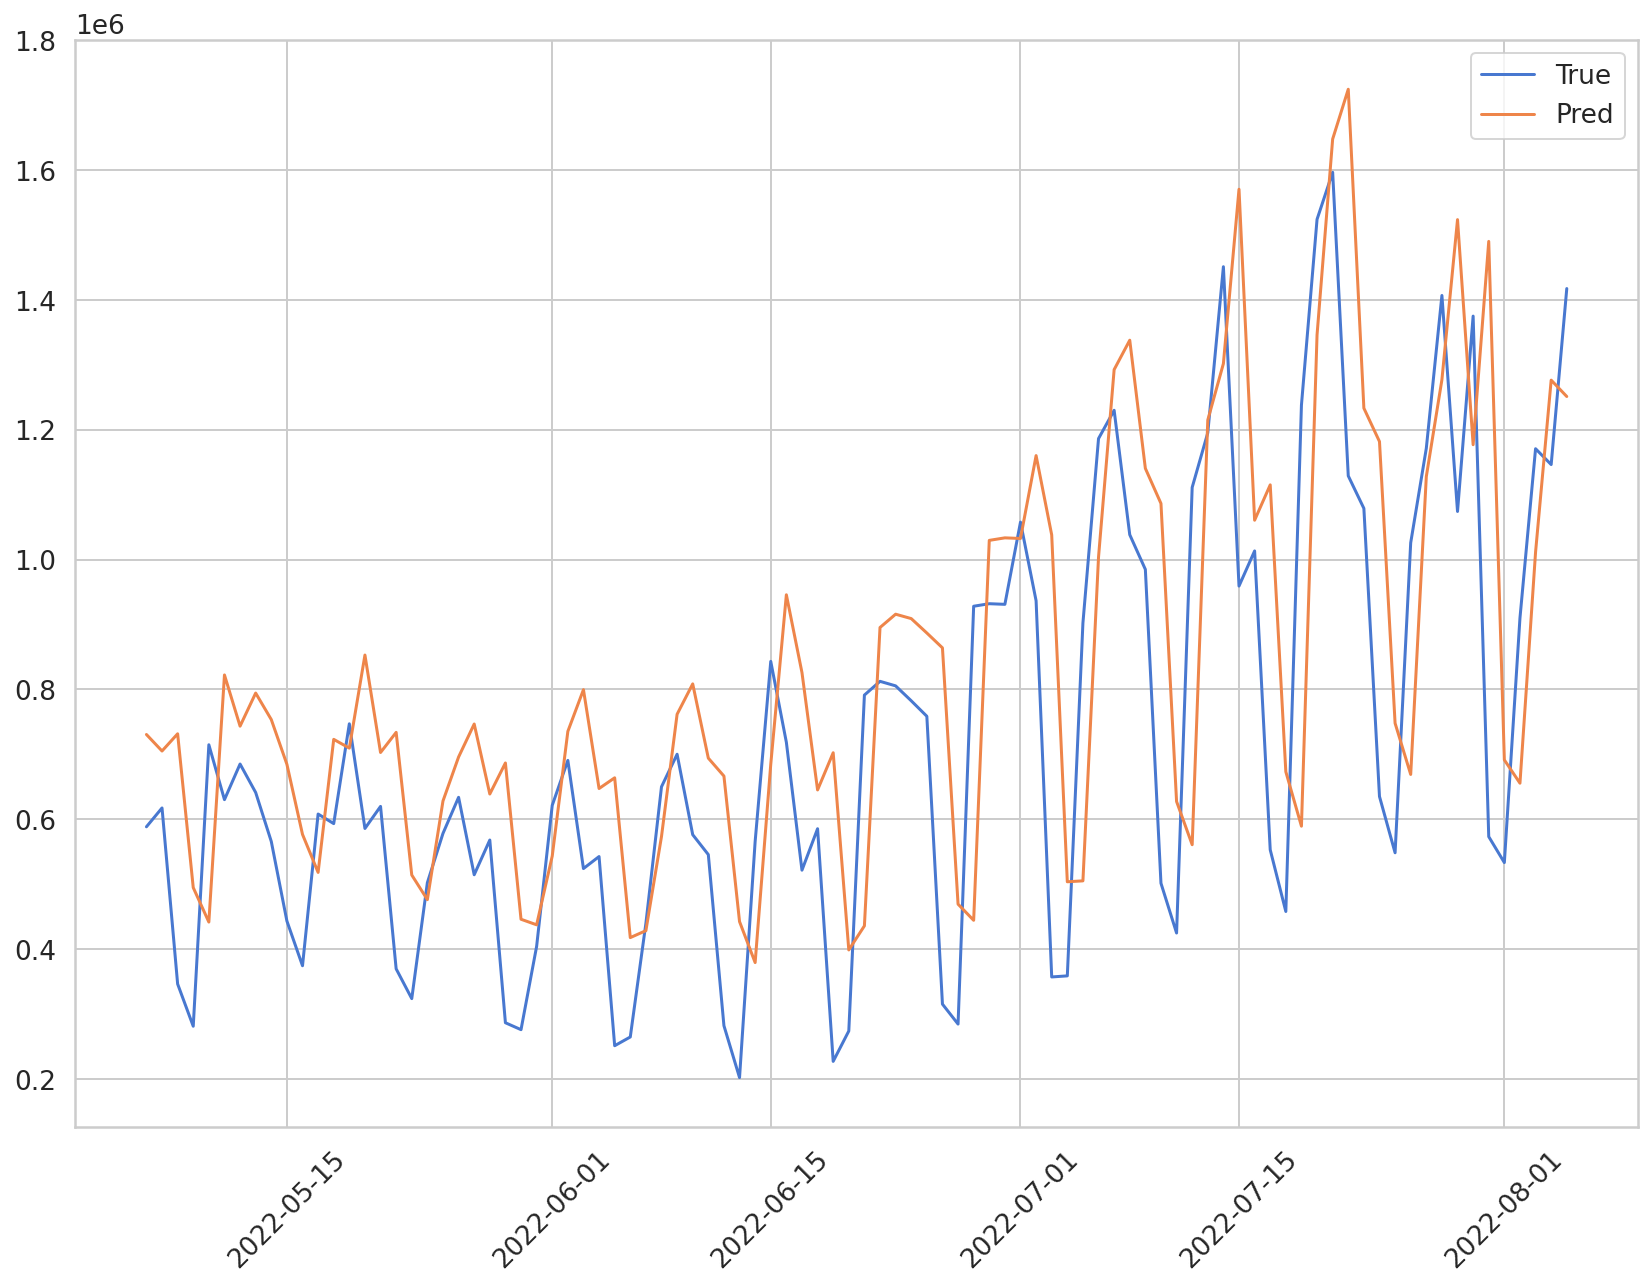

In [ ]:
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(daily_cases.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

The blue line shows the true values, and the orange line reveals the predicted values. Although the model predicts the rising trend of new COVID-19 cases